# Predicting Bundesliga Match Results

In this project, we'll use Bundesliga match logs to build a model on predicting the winner of a match. We have scraped data from [https://fbref.com](https://fbref.com) and created a csv file in a separate notebook.

Our data spans six full seasons. We'll compare the performances of random forest, ridge and support vector classifiers from sklearn and xgboost classifier on our data set.

## Cleaning the data set

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, make_scorer, confusion_matrix, RocCurveDisplay
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('match_data.csv')
df.shape

(3672, 40)

In [3]:
df.head()

,Unnamed: 0,date,time,round,day,venue,result,gf,ga,opponent,...,prgdist,live,dead,tb,sw,crs,ti,ck,season,team
0,1,2022-08-05,20:30,Matchweek 1,Fri,Away,W,6,1,Eint Frankfurt,...,3374.0,623.0,35.0,7.0,4.0,14.0,11.0,6.0,2022-2023,Bayern Munich
1,2,2022-08-14,17:30,Matchweek 2,Sun,Home,W,2,0,Wolfsburg,...,3508.0,592.0,50.0,1.0,5.0,20.0,23.0,8.0,2022-2023,Bayern Munich
2,3,2022-08-21,17:30,Matchweek 3,Sun,Away,W,7,0,Bochum,...,3056.0,498.0,42.0,3.0,2.0,10.0,16.0,5.0,2022-2023,Bayern Munich
3,4,2022-08-27,18:30,Matchweek 4,Sat,Home,D,1,1,M'Gladbach,...,3614.0,621.0,47.0,1.0,7.0,33.0,20.0,14.0,2022-2023,Bayern Munich
4,6,2022-09-03,15:30,Matchweek 5,Sat,Away,D,1,1,Union Berlin,...,3464.0,710.0,50.0,6.0,2.0,17.0,17.0,7.0,2022-2023,Bayern Munich


In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
# Check if there are any missing matches
df['round'].value_counts().sort_values()

round
Matchweek 1     108
Matchweek 4     108
Matchweek 5     108
Matchweek 6     108
Matchweek 7     108
Matchweek 8     108
Matchweek 9     108
Matchweek 10    108
Matchweek 11    108
Matchweek 12    108
Matchweek 13    108
Matchweek 14    108
Matchweek 15    108
Matchweek 16    108
Matchweek 17    108
Matchweek 18    108
Matchweek 19    108
Matchweek 33    108
Matchweek 26    108
Matchweek 20    108
Matchweek 21    108
Matchweek 22    108
Matchweek 23    108
Matchweek 24    108
Matchweek 3     108
Matchweek 25    108
Matchweek 2     108
Matchweek 28    108
Matchweek 29    108
Matchweek 30    108
Matchweek 31    108
Matchweek 32    108
Matchweek 27    108
Matchweek 34    108
Name: count, dtype: int64

We'll want to use time series cross validation a few steps later, therefore we sort our data set with respect to date and time of the matches.

In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
df = df.copy().sort_values(['date', 'time']).reset_index(drop=True)

In [8]:
pd.set_option('display.max_columns', None)
df.head()

,date,time,round,day,venue,result,gf,ga,opponent,xg,xga,poss,attendance,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,sota,saves,pka,pksv,cmp,att,totdist,prgdist,live,dead,tb,sw,crs,ti,ck,season,team
0,2017-08-18,20:30,Matchweek 1,Fri,Home,W,3,1,Leverkusen,2.6,1.6,52.0,75000.0,Thomas Müller,4-3-3,Tobias Stieler,12.0,7.0,16.9,0.0,1.0,1.0,4.0,3.0,0.0,0.0,459.0,547.0,9407.0,3624.0,483.0,59.0,0.0,8.0,14.0,22.0,4.0,2017-2018,Bayern Munich
1,2017-08-18,20:30,Matchweek 1,Fri,Away,L,1,3,Bayern Munich,1.6,2.6,48.0,75000.0,Bernd Leno,4-2-3-1,Tobias Stieler,19.0,4.0,17.8,1.0,0.0,0.0,8.0,5.0,1.0,0.0,437.0,515.0,7391.0,2588.0,468.0,46.0,5.0,4.0,10.0,12.0,5.0,2017-2018,Bayer Leverkusen
2,2017-08-19,15:30,Matchweek 1,Sat,Home,W,1,0,Werder Bremen,1.0,0.9,64.0,30150.0,Kevin Vogt,3-1-4-2,Guido Winkmann,14.0,3.0,23.4,1.0,0.0,0.0,2.0,2.0,0.0,0.0,561.0,666.0,10135.0,3589.0,612.0,51.0,1.0,0.0,20.0,24.0,6.0,2017-2018,Hoffenheim
3,2017-08-19,15:30,Matchweek 1,Sat,Away,W,3,0,Wolfsburg,1.0,0.4,69.0,30000.0,Sokratis Papastathopoulos,4-3-3,Robert Hartmann,13.0,5.0,19.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,554.0,697.0,10637.0,3830.0,640.0,57.0,0.0,3.0,13.0,33.0,5.0,2017-2018,Dortmund
4,2017-08-19,15:30,Matchweek 1,Sat,Away,L,0,2,Hertha BSC,1.0,0.5,47.0,44751.0,Christian Gentner,4-4-2,Sascha Stegemann,8.0,2.0,17.3,1.0,0.0,0.0,4.0,2.0,0.0,0.0,388.0,491.0,6661.0,2278.0,437.0,51.0,0.0,2.0,12.0,23.0,1.0,2017-2018,Stuttgart


There are inconsistencies in the team names in `team` and `opponent` columns; below we look at the different occurences of the same team, and standardize the names.

In [9]:
team_set = set(df['team'].unique())
opp_set = set(df['opponent'].unique())

diff = (team_set - opp_set) | (opp_set - team_set)
diff


{'Bayer Leverkusen',
 'Dusseldorf',
 'Düsseldorf',
 'Eint Frankfurt',
 'Eintracht Frankfurt',
 'Greuther Furth',
 'Greuther Fürth',
 'Koln',
 'Köln',
 'Leverkusen',
 "M'Gladbach",
 'Monchengladbach',
 'Nurnberg',
 'Nürnberg'}

In [10]:
map_values = {
    'Koln':'Köln',
    'Leverkusen': 'Bayer Leverkusen',
    'Dusseldorf': 'Düsseldorf',
    'Eint Frankfurt': 'Eintracht Frankfurt',
    'Greuther Furth': 'Greuther Fürth',
    "M'Gladbach": 'Monchengladbach',
    'Nurnberg': 'Nürnberg'
}

df.replace({'team':map_values, 'opponent':map_values}, inplace=True)

We need to take care of null values in order to use most machine learning models. Below we observe that the `attendance` column has a lot of null values. We remove this column altogether since it is not necessary for our purposes. We also observe that all other null values appear in three rows, which we also remove.

In [11]:
df.isna().sum().sort_values(ascending=False)

attendance    744
dist            3
fk              2
xg              2
cmp             2
att             2
totdist         2
prgdist         2
live            2
xga             2
dead            2
tb              2
sw              2
ti              2
ck              2
sota            0
crs             0
pksv            0
season          0
pka             0
saves           0
date            0
pkatt           0
opponent        0
round           0
day             0
venue           0
result          0
gf              0
ga              0
poss            0
pk              0
captain         0
formation       0
referee         0
sh              0
sot             0
time            0
team            0
dtype: int64

In [12]:
df.drop('attendance', axis=1, inplace=True)

In [13]:
df[df['dist'].isna()]

,date,time,round,day,venue,result,gf,ga,opponent,xg,xga,poss,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,sota,saves,pka,pksv,cmp,att,totdist,prgdist,live,dead,tb,sw,crs,ti,ck,season,team
1969,2020-11-21,15:30,Matchweek 8,Sat,Home,L,1,2,Bayer Leverkusen,0.0,1.2,31.0,Fabian Klos,4-1-4-1,Felix Brych,0.0,0.0,NaN,0.0,0.0,0.0,4.0,2.0,0.0,0.0,239.0,365.0,4896.0,2155.0,326.0,36.0,0.0,1.0,9.0,18.0,0.0,2020-2021,Arminia
2914,2022-03-18,20:30,Matchweek 27,Fri,Away,W,2,0,Bochum,NaN,NaN,49.0,Yann Sommer,3-4-3,Benjamin Cortus,8.0,5.0,NaN,NaN,0.0,0.0,7.0,7.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,2021-2022,Monchengladbach
2915,2022-03-18,20:30,Matchweek 27,Fri,Home,L,0,2,Monchengladbach,NaN,NaN,51.0,Anthony Losilla,4-3-3,Benjamin Cortus,16.0,7.0,NaN,NaN,0.0,0.0,5.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,2021-2022,Bochum


In [14]:
df.drop(df[df['dist'].isna()].index, inplace=True)


In [15]:
# Check total number of null values
df.isna().sum().sum()

0

In [16]:
df.shape

(3669, 38)

## Selecting features

The values in our target column consist of three categories: W(in), D(raw), and L(ose). We'll simplify our target into two categories corresponding to whether the team has won or not.

In [17]:
df['target'] = (df['result'] == 'W').astype(int)

In [18]:
df['target'].value_counts()

target
0    2287
1    1382
Name: count, dtype: int64

There are a couple of columns containing categorical data that are relevant for our purposes. Below we encode these columns into a numerical format. We also simplify a couple of time related columns.

In [19]:
df['venue_code'] = (df['venue'] == 'Home').astype(int)

In [20]:
df['opp_code'] = df['opponent'].astype('category').cat.codes

In [21]:
teams = df[['opponent', 'opp_code']][~df['opponent'].duplicated()]
teams

,opponent,opp_code
0,Bayer Leverkusen,2
1,Bayern Munich,3
2,Werder Bremen,23
3,Wolfsburg,24
4,Hertha BSC,12
5,Stuttgart,21
6,Hoffenheim,13
7,Hamburger SV,10
8,Mainz 05,15
9,Hannover 96,11


In [22]:
# Apply the same category codes as 'opp_code' to 'team_code'
teams_dict = dict(zip(teams['opponent'], teams['opp_code']))
df['team_code'] = df['team'].map(teams_dict).astype(int)

In [23]:
df['hour'] = df['time'].str.replace(r":.+", '', regex=True).astype(int)

In [24]:
df['day_code'] = df['date'].dt.dayofweek

In [25]:
df.head()

,date,time,round,day,venue,result,gf,ga,opponent,xg,xga,poss,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,sota,saves,pka,pksv,cmp,att,totdist,prgdist,live,dead,tb,sw,crs,ti,ck,season,team,target,venue_code,opp_code,team_code,hour,day_code
0,2017-08-18,20:30,Matchweek 1,Fri,Home,W,3,1,Bayer Leverkusen,2.6,1.6,52.0,Thomas Müller,4-3-3,Tobias Stieler,12.0,7.0,16.9,0.0,1.0,1.0,4.0,3.0,0.0,0.0,459.0,547.0,9407.0,3624.0,483.0,59.0,0.0,8.0,14.0,22.0,4.0,2017-2018,Bayern Munich,1,1,2,3,20,4
1,2017-08-18,20:30,Matchweek 1,Fri,Away,L,1,3,Bayern Munich,1.6,2.6,48.0,Bernd Leno,4-2-3-1,Tobias Stieler,19.0,4.0,17.8,1.0,0.0,0.0,8.0,5.0,1.0,0.0,437.0,515.0,7391.0,2588.0,468.0,46.0,5.0,4.0,10.0,12.0,5.0,2017-2018,Bayer Leverkusen,0,0,3,2,20,4
2,2017-08-19,15:30,Matchweek 1,Sat,Home,W,1,0,Werder Bremen,1.0,0.9,64.0,Kevin Vogt,3-1-4-2,Guido Winkmann,14.0,3.0,23.4,1.0,0.0,0.0,2.0,2.0,0.0,0.0,561.0,666.0,10135.0,3589.0,612.0,51.0,1.0,0.0,20.0,24.0,6.0,2017-2018,Hoffenheim,1,1,23,13,15,5
3,2017-08-19,15:30,Matchweek 1,Sat,Away,W,3,0,Wolfsburg,1.0,0.4,69.0,Sokratis Papastathopoulos,4-3-3,Robert Hartmann,13.0,5.0,19.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,554.0,697.0,10637.0,3830.0,640.0,57.0,0.0,3.0,13.0,33.0,5.0,2017-2018,Dortmund,1,0,24,5,15,5
4,2017-08-19,15:30,Matchweek 1,Sat,Away,L,0,2,Hertha BSC,1.0,0.5,47.0,Christian Gentner,4-4-2,Sascha Stegemann,8.0,2.0,17.3,1.0,0.0,0.0,4.0,2.0,0.0,0.0,388.0,491.0,6661.0,2278.0,437.0,51.0,0.0,2.0,12.0,23.0,1.0,2017-2018,Stuttgart,0,0,12,21,15,5


The five features we have so far relate to which teams are playing, and the venue and the time of the match.

In [26]:
predictors = ['team_code', 'opp_code', 'venue_code', 'hour', 'day_code']

## Models

We'll keep the last season as our validation set, and the previous seaons will be our training set. In order to make sure we use previous match logs to predict later matches, we will use time series cross validation on our training set.

In [27]:
train = df[df['date'] < '2022-07-01']
val = df[df['date'] > '2022-07-01']

X = train[predictors]
y = train['target']

X_val = val[predictors]
y_val = val['target']

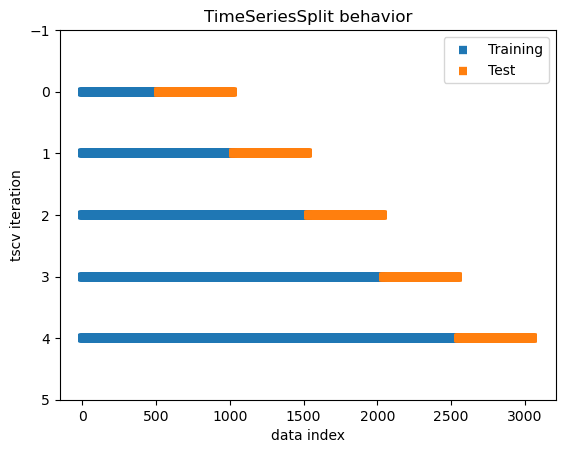

In [28]:
tscv = TimeSeriesSplit(n_splits=5)

# Visualize the splits as a sanity check
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(tscv.split(X, y)):
    l1 = ax.scatter(tr, [ii] * len(tr), c='tab:blue',
                    marker='_', lw=6)
    l2 = ax.scatter(tt, [ii] * len(tt), c='tab:orange',
                    marker='_', lw=6)
ax.set(ylim=[5, -1],
       title='TimeSeriesSplit behavior',
       xlabel='data index', ylabel='tscv iteration')
ax.legend([l1, l2], ['Training', 'Test'])
plt.show()

We will use f1 score as our main metric.

In [29]:
f1_scorer = make_scorer(f1_score)

def scores(model):
    f1 = cross_val_score(model, X[predictors], y, cv=tscv, scoring=f1_scorer)
    print("Cross validation on training set:")
    print(f"f1 scores: {f1}")
    print(f"mean f1 score: {np.mean(f1)}")
    print(f"standard deviation of f1 scores: {np.std(f1)}", end='\n\n')

    model.fit(X[predictors], y)
    preds = model.predict(X_val[predictors])

    print("Validation set:")
    print(f"f1 score: {f1_score(y_val, preds)}")
    print(f"accuracy score: {accuracy_score(y_val, preds)}")

    print(f"roc_auc score: {roc_auc_score(y_val, preds)}")

    cm = confusion_matrix(y_val, preds)
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = ['{0:0.0f}'.format(v) for v in cm.flatten()]
    percentages = ['{0:.2%}'.format(v) for v in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot=labels, cmap='Blues', fmt='')
    plt.show()

We'll apply a few machine learning models on our data set. For each model, we'll do the following:

1. Use training set and a pipeline to

    - determine the number of features to use
    - select these features
    - tune the parameters of the model using grid search  
<br>

2. Use training set and sequential feature selection with the parameters of the previuos step

3. Note the performance of the resulting model on both training and validation sets

### Model 1: Random forest classifier

In [30]:
params = {
    'n_estimators': [100, 200, 300],
    'min_samples_split': range(2, 11, 2),
    'max_depth': range(3, 8)
}

gs = GridSearchCV(RandomForestClassifier(random_state=1),
                  param_grid=params,
                  cv=tscv,
                  scoring=f1_scorer
                  )

gs.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': range(3, 8),
                         'min_samples_split': range(2, 11, 2),
                         'n_estimators': [100, 200, 300]},
             scoring=make_scorer(f1_score))

In [31]:
gs.best_params_

{'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 100}

Cross validation on training set:
f1 scores: [0.39175258 0.32432432 0.42857143 0.40701754 0.3630137 ]
mean f1 score: 0.3829359145410253
standard deviation of f1 scores: 0.036255956058391686

Validation set:
f1 score: 0.3473053892215569
accuracy score: 0.6437908496732027
roc_auc score: 0.5664860074308893


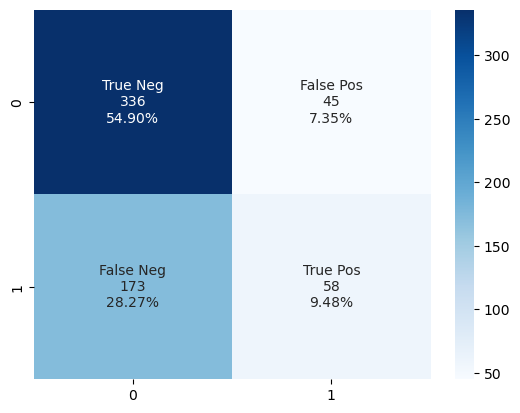

In [32]:
rf = RandomForestClassifier(**gs.best_params_, random_state=1)

scores(rf)

### Model 2: Ridge classifier

In [33]:
params = {
    'alpha': [round(a * 0.1, 1) for a in range(1, 11)]
}

gs = GridSearchCV(RidgeClassifier(),
                  param_grid=params,
                  cv=tscv,
                  scoring=f1_scorer
                  )

gs.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RidgeClassifier(),
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0]},
             scoring=make_scorer(f1_score))

In [34]:
gs.best_params_

{'alpha': 0.7}

Cross validation on training set:
f1 scores: [0.14912281 0.16101695 0.15246637 0.11607143 0.0990991 ]
mean f1 score: 0.1355553303107237
standard deviation of f1 scores: 0.023778279439015105

Validation set:
f1 score: 0.1076923076923077
accuracy score: 0.6209150326797386
roc_auc score: 0.5106179909329515


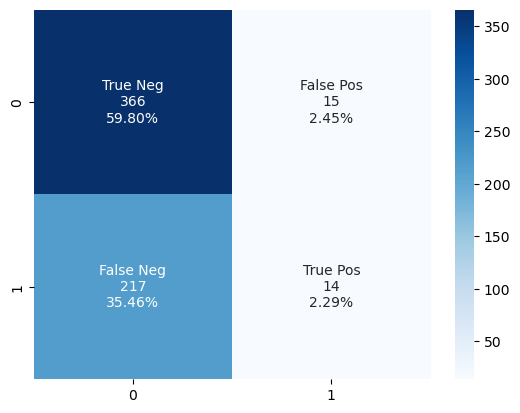

In [35]:
rc = RidgeClassifier(**gs.best_params_)

scores(rc)

### Model 3: Support vector classifier

In [36]:
params = {
    'C': [0.1, 1, 10]
    # kernel = ['linear', 'poly', 'rbf']
}

gs = GridSearchCV(SVC(),
                  param_grid=params,
                  cv=tscv,
                  scoring=f1_scorer
                  )

gs.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVC(), param_grid={'C': [0.1, 1, 10]},
             scoring=make_scorer(f1_score))

In [37]:
gs.best_params_

{'C': 10}

Cross validation on training set:
f1 scores: [0.0861244  0.0097561  0.04210526 0.1369863  0.05660377]
mean f1 score: 0.06631516751750292
standard deviation of f1 scores: 0.04304921361165949

Validation set:
f1 score: 0.0
accuracy score: 0.6225490196078431
roc_auc score: 0.5


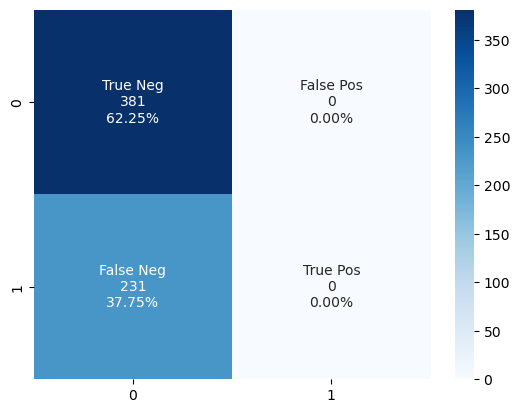

In [38]:
svc = SVC(**gs.best_params_)

scores(svc)

### Model 4: XGBoost Classifier

In [39]:
params = {
    'max_depth': range(3, 8),
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}

gs = GridSearchCV(XGBClassifier(),
                  param_grid=params,
                  cv=tscv,
                  scoring=f1_scorer
                  )

gs.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, im...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimato

In [40]:
gs.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}

Cross validation on training set:
f1 scores: [0.43930636 0.46723647 0.45747801 0.4957265  0.50828729]
mean f1 score: 0.47360692400544957
standard deviation of f1 scores: 0.025176405446453057

Validation set:
f1 score: 0.4860759493670886
accuracy score: 0.6683006535947712
roc_auc score: 0.6185533626478509


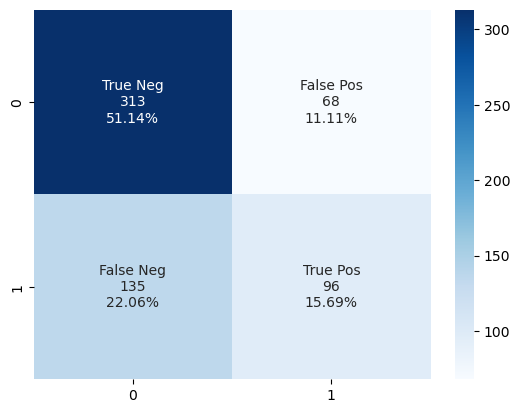

In [41]:
xgbc = XGBClassifier(**gs.best_params_, random_state=1)

scores(xgbc)

## Conclusion

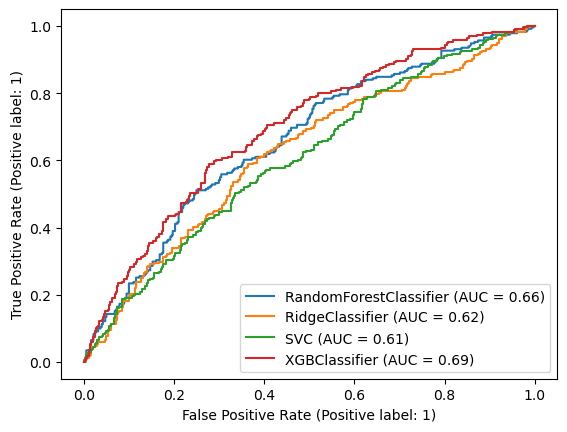

In [42]:
disp = RocCurveDisplay.from_estimator(rf, X_val[predictors], y_val)
RocCurveDisplay.from_estimator(rc, X_val[predictors], y_val, ax=disp.ax_)
RocCurveDisplay.from_estimator(svc, X_val[predictors], y_val, ax=disp.ax_)
RocCurveDisplay.from_estimator(xgbc, X_val[predictors], y_val, ax=disp.ax_)
plt.show()

We can see that xgboost classifier performed the best among the models we have built.

Random forest classifier perfomed slightly better than ridge classifier. Looking at the confusion matrix we can see that half of ridge classifier's win predictions are incorrect.

Support vector classifier performed poorly. In the confusion matrix we see that there were no matches where it predicted a win.

Before concluding, it is necessary to note that our data set is small, and our target is highly imbalanced towards 0 (recall we combined losses and draws of matches as 0).